In [ ]:
# 构建机器学习模型并训练：数据集训练测试切分、回归模型、分类模型、学习曲线可视化、分类结果评价标准（混淆矩阵）可视化、拟合曲线可视化、模型中特征重要性可视化、调参、树模型可视化
# python3.9 + sklearn + numpy + scipy + pandas + matplotlib + hyperopt (调参数) + bayesian-optimization (调参数 from bayes_opt import BayesianOptimization) + catboost （需要gpu）+ tensorflow 2.13 (keras)
# lightgbm + xgboost
# pip install bayesian-optimization=1.4.0

# 数据集训练测试切分：Hold-Out-Method、KFold、LeaveOneOut、LeavePOut、ShuffleSplit、StratifiedKFold分层K折交叉验证、StratifiedShuffleSplit。
# 分类评价标准：pre、recall、f1、acc、auc、mcc、混淆矩阵可视化。
# 回归模型：LinearRegression、Ridge、Lasso、ElasticNet、SVR、KNeighborsRegressor、DecisionTreeRegressor、RandomForestRegressor、GradientBoostingRegressor、xgboost.XGBRegressor、lightgbm.LGBMRegressor。
# 分类模型：LogisticRegression、KNeighborsClassifier、GaussianNB、tree、BaggingClassifier、RandomForestClassifier、ExtraTreesClassifier、AdaBoostClassifier、GradientBoostingClassifier、lightgbm.LGBMClassifier、xgboost.XGBClassifier。
# 模型习得特征重要性的可视化。
# 学习过程的可视化曲线。
# 拟合曲线、效果曲线、
# 正则化：L1、L2、elasticnet。
# 调参：GridSearchCV、RandomizedSearchCV。

# 重要模型：lightgbm模型、catboost、xgboost、RF，比赛也就是这几个模型的融合

In [1]:
# pandas和numpy：参数设置和读取文件
# 数据1：回归

import pandas as pd
import numpy as np

# pandas 参数设置
pd.set_option('display.max_columns',10)
pd.set_option('display.max_rows',20)
#禁用科学计数法
np.set_printoptions(suppress=True,   precision=10,  threshold=2000,  linewidth=150)  
pd.set_option('display.float_format',lambda x : '%.2f' % x)

# 读取数据
train_data = pd.read_csv("./data/zhengqi/zhengqi_train.txt", sep='\t', encoding='utf-8')
test_data = pd.read_csv("./data/zhengqi/zhengqi_test.txt", sep='\t', encoding='utf-8')

# 查看和统计
print('info:')
train_data.info()
print('\n\nhead(3):')
print(train_data.head(3))
print('\n\ndescribe:')
train_data.describe()

# dataframe简单操作
# data_all = pd.concat([train_data,test_data]) 
# data_all =  data_all.drop(['V0'], axis=1)
# data_all =  data_all.drop(['target'], axis=1, inplace=True)
# data_all = data_all[data_all['V9']>-7.5]
##删除异常值
train_data = train_data[train_data['V9']>-7.5]
test_data = test_data[test_data['V9']>-7.5]

##归一化数据
from sklearn import preprocessing
features_columns = [col for col in train_data.columns if col not in ['target']]
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler = min_max_scaler.fit(train_data[features_columns])
train_data_scaler = min_max_scaler.transform(train_data[features_columns])
test_data_scaler = min_max_scaler.transform(test_data[features_columns])

train_data_scaler = pd.DataFrame(train_data_scaler)
train_data_scaler.columns = features_columns
test_data_scaler = pd.DataFrame(test_data_scaler)
test_data_scaler.columns = features_columns
train_data_scaler['target'] = train_data['target']

##PCA降维 保持90%的信息
from sklearn.decomposition import PCA   #主成分分析法
pca = PCA(n_components=0.9)
new_train_pca_90 = pca.fit_transform(train_data_scaler.iloc[:,0:-1])
new_test_pca_90 = pca.transform(test_data_scaler)
new_train_pca_90 = pd.DataFrame(new_train_pca_90)
new_test_pca_90 = pd.DataFrame(new_test_pca_90)
new_train_pca_90['target'] = train_data_scaler['target']

pca = PCA(n_components=0.95)
new_train_pca_16 = pca.fit_transform(train_data_scaler.iloc[:,0:-1])
new_test_pca_16 = pca.transform(test_data_scaler)
new_train_pca_16 = pd.DataFrame(new_train_pca_16)
new_test_pca_16 = pd.DataFrame(new_test_pca_16)
new_train_pca_16['target'] = train_data_scaler['target']

info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2888 entries, 0 to 2887
Data columns (total 39 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V0      2888 non-null   float64
 1   V1      2888 non-null   float64
 2   V2      2888 non-null   float64
 3   V3      2888 non-null   float64
 4   V4      2888 non-null   float64
 5   V5      2888 non-null   float64
 6   V6      2888 non-null   float64
 7   V7      2888 non-null   float64
 8   V8      2888 non-null   float64
 9   V9      2888 non-null   float64
 10  V10     2888 non-null   float64
 11  V11     2888 non-null   float64
 12  V12     2888 non-null   float64
 13  V13     2888 non-null   float64
 14  V14     2888 non-null   float64
 15  V15     2888 non-null   float64
 16  V16     2888 non-null   float64
 17  V17     2888 non-null   float64
 18  V18     2888 non-null   float64
 19  V19     2888 non-null   float64
 20  V20     2888 non-null   float64
 21  V21     2888 non-null   float64

In [55]:
# 另一个数据集(分类数据)，统计离散值并可视化，节约内存小技巧
# 数据集2：分类
# 读取特征工程后的特征数据

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

train_data = pd.read_csv('./data/tmall/train_all.csv',nrows=10000)
test_data = pd.read_csv('./data/tmall/test_all.csv',nrows=100)

features_columns = [col for col in train_data.columns if col not in ['user_id','label']]
train = train_data[features_columns].values
test = test_data[features_columns].values
target =train_data['label'].values


X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.4, random_state=0)
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)
clf = clf.fit(X_train, y_train)
scores = clf.score(X_test, y_test)
print("(train_test_split) Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2)) 

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)
scores = cross_val_score(clf, train, target, cv=5)
print("(cross_val_score) Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(clf, train, target, cv=5, scoring='f1_macro')
print("(cross_val_score) F1: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scores = cross_val_score(clf, train, target, cv=cv)  
print("(cross_val_score) Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))


(train_test_split) Accuracy: 0.9275 (+/- 0.0000)
(cross_val_score) Accuracy: 0.9355 (+/- 0.0020)
(cross_val_score) F1: 0.4833 (+/- 0.0005)
(cross_val_score) Accuracy: 0.9343 (+/- 0.0109)


In [1]:
# 读取数据集: 
# 数据集4：时间序列-kaggle销量预测

import pickle
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

with open('./data/kaggleSalesForecasting/X_train.pickle', 'rb') as f:
    X_train = pickle.load(f)
with open('./data/kaggleSalesForecasting/y_train.pickle', 'rb') as f:
    y_train = pickle.load(f)
with open('./data/kaggleSalesForecasting/X_val.pickle', 'rb') as f:
    X_val = pickle.load(f)
with open('./data/kaggleSalesForecasting/y_val.pickle', 'rb') as f:
    y_val = pickle.load(f)
with open('./data/kaggleSalesForecasting/X_test.pickle', 'rb') as f:
    X_test = pickle.load(f)
with open('./data/kaggleSalesForecasting/train_weight.pickle', 'rb') as f:
    train_weight = pickle.load(f)
with open('./data/kaggleSalesForecasting/val_weight.pickle', 'rb') as f:
    val_weight = pickle.load(f)

print(type(X_train), type(y_train), type(X_val), type(y_val), type(train_weight), type(val_weight))
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, len(train_weight), len(val_weight))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'> <class 'list'> <class 'list'>
(172339, 1538) (172339, 16) (172339, 1538) (172339, 16) 172339 172339


In [2]:
# 切分数据集： 
# 数据1：回归
from sklearn.model_selection import train_test_split  # 切分数据

new_train_pca_16 = new_train_pca_16.fillna(0)  #采用 pca 保留16维特征的数据
train = new_train_pca_16[new_test_pca_16.columns]
target = new_train_pca_16['target']


# 简单交叉验证Hold-Out-Method: 训练数据80% 验证数据20%
train_data, test_data, train_target, test_target = train_test_split(train, target, test_size=0.2, random_state=0)
print('Hold-Out:', train_data.shape, test_data.shape, train_target.shape, test_target.shape)

# K折交叉验证K-Fold-CV
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=0, shuffle=True)
print('KFold:')
for i, (train_index, test_index) in enumerate(kf.split(train_data.head(10))):
    print('\t', i, train_index, test_index)

# 留一法交叉验证LOO-CV:
from sklearn.model_selection import LeaveOneOut 
loo = LeaveOneOut()
print('LeaveOneOut:')
for i, (train_index, test_index) in enumerate(loo.split(train_data.head(10))):
    print('\t', i, train_index, test_index)

# 留P法交叉验证LPO-CV
from sklearn.model_selection import LeavePOut 
lpo = LeavePOut(p=2)
print('LeavePOut:')
for i, (train_index, test_index) in enumerate(lpo.split(train_data.head(10))):
    print('\t', i, train_index, test_index)

# 随机排列划分子集
from sklearn.model_selection import ShuffleSplit 
ss = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)
print('ShuffleSplit:')
for i, (train_index, test_index) in enumerate(ss.split(train_data.head(10))):
    print('\t', i, train_index, test_index)

# 分层K折交叉验证、分层随机交叉验证
from sklearn.model_selection import StratifiedKFold 
skf = StratifiedKFold(n_splits=3)  #各个类别的比例大致和完整数据集中相同
print('StratifiedKFold:')
for i, (train_index, test_index) in enumerate(skf.split(train_data.head(10).values[:,:-1], train_data.head(10).values[:,-1].astype(np.int8))):
    print('\t', i, train_index, test_index)

# 划分中每个类的比例和完整数据集中的相同
from sklearn.model_selection import StratifiedShuffleSplit 
sss = StratifiedShuffleSplit(n_splits=3)  
print('StratifiedShuffleSplit:')
for i, (train_index, test_index) in enumerate(sss.split(train_data.head(10).values[:,:-1], train_data.head(10).values[:,-1].astype(np.int8))):
    print('\t', i, train_index, test_index)




# =====组 k-fold交叉验证、留一组交叉验证、留 P 组交叉验证、Group Shuffle Split=====
X = [0.1, 0.2, 2.2, 2.4, 2.3, 4.55, 5.8, 8.8, 9, 10]
y = ["a", "b", "b", "b", "c", "c", "c", "d", "d", "d"]
groups = [1, 1, 1, 2, 2, 2, 3, 3, 3, 3]

# k折分组
from sklearn.model_selection import GroupKFold 
gkf = GroupKFold(n_splits=3)  # 训练集和测试集属于不同的组
print('GroupKFold:')
for i, (train_index, test_index) in enumerate(gkf.split(X, y, groups=groups)):
    print('\t', i, train_index, test_index)

# 留一分组
from sklearn.model_selection import LeaveOneGroupOut 
logo = LeaveOneGroupOut()
print('LeaveOneGroupOut:')
for i, (train_index, test_index) in enumerate(logo.split(X, y, groups=groups)):
    print('\t', i, train_index, test_index)

# 留p分组
from sklearn.model_selection import LeavePGroupsOut 
lpgo = LeavePGroupsOut(n_groups=2)
print('LeavePGroupsOut:')
for i, (train_index, test_index) in enumerate(lpgo.split(X, y, groups=groups)):
    print('\t', i, train_index, test_index)

# 随机分组
from sklearn.model_selection import GroupShuffleSplit 
gss = GroupShuffleSplit(n_splits=4, test_size=0.5, random_state=0)
print('GroupShuffleSplit:')
for i, (train_index, test_index) in enumerate(gss.split(X, y, groups=groups)):
    print('\t', i, train_index, test_index)


# =====时间序列分割=====
from sklearn.model_selection import TimeSeriesSplit 
tscv = TimeSeriesSplit(n_splits=3)
# TimeSeriesSplit(max_train_size=None, n_splits=3)
print('TimeSeriesSplit:')
for i, (train_index, test_index) in enumerate(tscv.split(train_data.head(10))):
    print('\t', i, train_index, test_index)

Hold-Out: (2308, 21) (578, 21) (2308,) (578,)
KFold:
	 0 [0 1 3 4 5 6 7 9] [2 8]
	 1 [0 1 2 3 5 6 7 8] [4 9]
	 2 [0 2 3 4 5 7 8 9] [1 6]
	 3 [0 1 2 4 5 6 8 9] [3 7]
	 4 [1 2 3 4 6 7 8 9] [0 5]
LeaveOneOut:
	 0 [1 2 3 4 5 6 7 8 9] [0]
	 1 [0 2 3 4 5 6 7 8 9] [1]
	 2 [0 1 3 4 5 6 7 8 9] [2]
	 3 [0 1 2 4 5 6 7 8 9] [3]
	 4 [0 1 2 3 5 6 7 8 9] [4]
	 5 [0 1 2 3 4 6 7 8 9] [5]
	 6 [0 1 2 3 4 5 7 8 9] [6]
	 7 [0 1 2 3 4 5 6 8 9] [7]
	 8 [0 1 2 3 4 5 6 7 9] [8]
	 9 [0 1 2 3 4 5 6 7 8] [9]
LeavePOut:
	 0 [2 3 4 5 6 7 8 9] [0 1]
	 1 [1 3 4 5 6 7 8 9] [0 2]
	 2 [1 2 4 5 6 7 8 9] [0 3]
	 3 [1 2 3 5 6 7 8 9] [0 4]
	 4 [1 2 3 4 6 7 8 9] [0 5]
	 5 [1 2 3 4 5 7 8 9] [0 6]
	 6 [1 2 3 4 5 6 8 9] [0 7]
	 7 [1 2 3 4 5 6 7 9] [0 8]
	 8 [1 2 3 4 5 6 7 8] [0 9]
	 9 [0 3 4 5 6 7 8 9] [1 2]
	 10 [0 2 4 5 6 7 8 9] [1 3]
	 11 [0 2 3 5 6 7 8 9] [1 4]
	 12 [0 2 3 4 6 7 8 9] [1 5]
	 13 [0 2 3 4 5 7 8 9] [1 6]
	 14 [0 2 3 4 5 6 8 9] [1 7]
	 15 [0 2 3 4 5 6 7 9] [1 8]
	 16 [0 2 3 4 5 6 7 8] [1 9]
	 17 [0 1 4 5 6 7 8 

acc = 0.926 auc = 0.49571734475374735 mcc = -0.023871938507169333
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       467
         1.0       0.00      0.00      0.00        33

    accuracy                           0.93       500
   macro avg       0.47      0.50      0.48       500
weighted avg       0.87      0.93      0.90       500

Confusion matrix, without normalization
[[463   4]
 [ 33   0]]
Normalized confusion matrix
[[0.99 0.01]
 [1.   0.  ]]


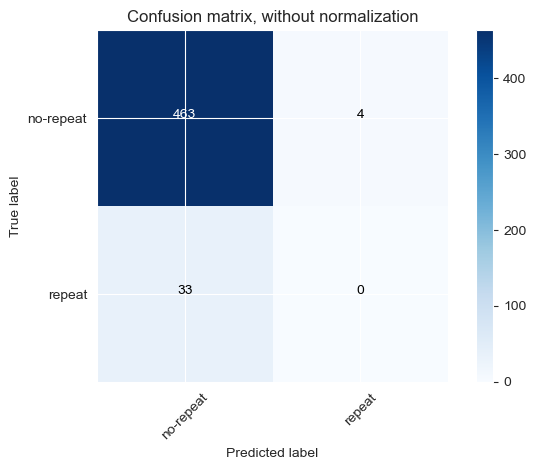

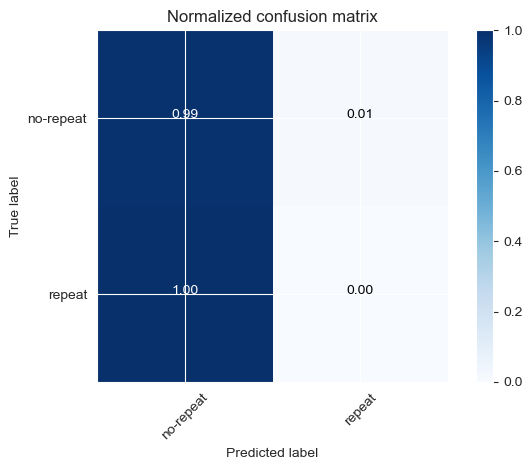

In [3]:
# 分类评价：混淆矩阵、auc等
# 数据集2：分类

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, matthews_corrcoef
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# label name
class_names = ['no-repeat', 'repeat']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
clf = RandomForestClassifier(n_jobs=-1)
y_pred = clf.fit(X_train, y_train).predict(X_test)
# 不同评价标准下的结果
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
print('acc =', acc, 'auc =', auc, 'mcc =', mcc)
print(classification_report(y_test, y_pred))


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [33]:
# 线性回归模型 LinearRegression
# 数据1：回归

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

clf = LinearRegression()
%time clf.fit(train_data, train_target)
test_pred = clf.predict(test_data)
score = mean_squared_error(test_target, clf.predict(test_data))
print("LinearRegression:   ", score)

Wall time: 0 ns
LinearRegression:    0.2642337917628173


In [73]:
# 岭回归模型 Ridge
# 数据1：回归

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

clf = Ridge()
%time clf.fit(train_data, train_target)
test_pred = clf.predict(test_data)
score = mean_squared_error(test_target, clf.predict(test_data))
print("Ridge:   ", score)

Wall time: 0 ns
Ridge:    0.26390267274268325


In [74]:
# Lasso回归模型 Lasso
# 数据1：回归

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

clf = Lasso()
%time clf.fit(train_data, train_target)
test_pred = clf.predict(test_data)
score = mean_squared_error(test_target, clf.predict(test_data))
print("Lasso:   ", score)

Wall time: 76.2 ms
Lasso:    1.0272506955811558


In [75]:
# ElasticNet回归模型 ElasticNet
# 数据1：回归

from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

clf = ElasticNet()
%time clf.fit(train_data, train_target)
test_pred = clf.predict(test_data)
score = mean_squared_error(test_target, clf.predict(test_data))
print("ElasticNet:   ", score)

Wall time: 75.3 µs
ElasticNet:    1.0272506955811558


In [77]:
# SVR回归模型 SVR
# 数据1：回归

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

clf = SVR()
%time clf.fit(train_data, train_target)
test_pred = clf.predict(test_data)
score = mean_squared_error(test_target, clf.predict(test_data))
print("SVR:   ", score)

Wall time: 430 ms
SVR:    0.216637323528845


In [34]:
# K近邻回归模型算法
# 数据1：回归

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

clf = KNeighborsRegressor(n_neighbors=3)  # 最近三个
%time clf.fit(train_data, train_target)
test_pred = clf.predict(test_data)
score = mean_squared_error(test_target, clf.predict(test_data))
print("KNeighborsRegressor:   ", score)

Wall time: 0 ns
KNeighborsRegressor:    0.27619208861976163


In [16]:
# 决策回归树模型算法
# 数据1：回归

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

clf = DecisionTreeRegressor()
%time clf.fit(train_data, train_target)
test_pred = clf.predict(test_data)
score = mean_squared_error(test_target, clf.predict(test_data))
print("DecisionTreeRegressor:   ", score)

Wall time: 62.5 ms
DecisionTreeRegressor:    0.6050157525951557


In [17]:
# 随机森林回归树模型算法 (**)
# 数据1：回归

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

clf = RandomForestRegressor(n_estimators=200) # 200棵树模型
%time clf.fit(train_data, train_target)
test_pred = clf.predict(test_data)
score = mean_squared_error(test_target, clf.predict(test_data))
print("RandomForestRegressor:   ", score)

Wall time: 5.32 s
RandomForestRegressor:    0.24614504410601207


In [78]:
# GBDT模型 GradientBoostingRegressor (*)
# 数据1：回归

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

clf = GradientBoostingRegressor()
%time clf.fit(train_data, train_target)
test_pred = clf.predict(test_data)
score = mean_squared_error(test_target, clf.predict(test_data))
print("GradientBoostingRegressor:   ", score)

Wall time: 1.16 s
GradientBoostingRegressor:    0.27728686198310526


In [4]:
# XGB模型 XGBRegressor (**)
# 数据1：回归

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

clf = XGBRegressor(objective='reg:squarederror')
%time clf.fit(train_data, train_target)
test_pred = clf.predict(test_data)
score = mean_squared_error(test_target, clf.predict(test_data))
print("XGBRegressor:   ", score)

CPU times: user 2.35 s, sys: 631 ms, total: 2.98 s
Wall time: 472 ms
XGBRegressor:    0.26703937432297636


In [5]:
# lgb回归模型 (***)
# 数据1：回归
# 如果pip3 install lightgbm安装有问题，则lightgbm在conda里安装

from lightgbm import LGBMRegressor #lightGbm模型
from sklearn.metrics import mean_squared_error
clf = LGBMRegressor(
    learning_rate=0.01,
    max_depth=-1,
    n_estimators=5000,
    boosting_type='gbdt',
    random_state=2019,
    objective='regression',
)
# 训练模型
%time clf.fit(X=train_data, y=train_target, eval_metric='MSE', verbose=50)
score = mean_squared_error(test_target, clf.predict(test_data))
print("lightGbm:   ", score)

CPU times: user 34.3 s, sys: 2.24 s, total: 36.5 s
Wall time: 4.73 s
lightGbm:    0.23134714151049274


In [11]:
# LR模型 LogisticRegression
# 数据2：分类

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, target, random_state=0)
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
%time clf.fit(X_train, y_train)
clf.score(X_test, y_test)

CPU times: user 2.15 s, sys: 39.1 ms, total: 2.19 s
Wall time: 327 ms


0.926

In [3]:
# KNN模型 KNeighborsClassifier
# 数据2：分类

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, target, random_state=0)
clf = KNeighborsClassifier(n_neighbors=3)
%time clf.fit(X_train, y_train)
clf.score(X_test, y_test)

CPU times: user 981 µs, sys: 56 µs, total: 1.04 ms
Wall time: 1.05 ms


AttributeError: dlsym(0x9ade32b0, openblas_get_parallel): symbol not found

In [5]:
# NB模型 GaussianNB
# 数据2：分类

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, target, random_state=0)
%time clf = GaussianNB().fit(X_train, y_train)
clf.score(X_test, y_test)

CPU times: user 3.79 ms, sys: 1.55 ms, total: 5.33 ms
Wall time: 5.37 ms


0.424

In [7]:
# 树模型 tree
# 数据2：分类

from sklearn import tree
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)
clf = tree.DecisionTreeClassifier()
%time clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

CPU times: user 77.9 ms, sys: 400 µs, total: 78.3 ms
Wall time: 78.6 ms


0.864

In [9]:
# bagging模型 BaggingClassifier
# 数据2：分类

from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)
clf = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)
%time clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

CPU times: user 14.7 ms, sys: 1.18 ms, total: 15.9 ms
Wall time: 15.9 ms


AttributeError: dlsym(0x9ade32b0, openblas_get_parallel): symbol not found

In [10]:
# 随机森林模型 RandomForestClassifier (**)
# 数据2：分类

from sklearn.ensemble import RandomForestClassifier
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)
clf = clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
%time clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

CPU times: user 37.7 ms, sys: 267 µs, total: 38 ms
Wall time: 38.2 ms


0.93

In [12]:
# 随机森林模型 ExtraTreesClassifier
# 数据2：分类

from sklearn.ensemble import ExtraTreesClassifier
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)
clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
%time clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

CPU times: user 28.2 ms, sys: 656 µs, total: 28.9 ms
Wall time: 28.9 ms


0.924

In [14]:
# AdaBoost模型 AdaBoostClassifier (*)
# 数据2：分类

from sklearn.ensemble import AdaBoostClassifier
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)
clf = AdaBoostClassifier(n_estimators=100)
%time clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

CPU times: user 491 ms, sys: 2.24 ms, total: 493 ms
Wall time: 501 ms


0.928

In [15]:
# GradientBoosting模型 GradientBoostingClassifier (*)
# 数据2：分类

from sklearn.ensemble import GradientBoostingClassifier
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
%time clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

CPU times: user 374 ms, sys: 1.61 ms, total: 375 ms
Wall time: 384 ms


0.926

In [48]:
# lightgbm模型 lightgbm (***)
# 数据2：分类

import lightgbm
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.4, random_state=0)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

clf = lightgbm
train_matrix = clf.Dataset(X_train, label=y_train)
test_matrix = clf.Dataset(X_test, label=y_test)
params = {'boosting_type': 'gbdt', #'boosting_type': 'dart',
          'objective': 'multiclass', 'metric': 'multi_logloss', 'min_child_weight': 1.5, 'num_leaves': 2**5,
          'lambda_l2': 10, 'subsample': 0.7, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'learning_rate': 0.03,
          'tree_method': 'exact', 'seed': 2017, "num_class": 2, 'silent': True, 'verbose': -1}
# params = {'boosting_type': 'gbdt', 'objective': 'binary', 'eval_metric': 'auc', 'n_estimators': 200, 'max_depth': 5, 'num_leaves': 40, 
#     'max_bin': 400, 'min_data_in_leaf': 120, 'learning_rate': 0.1, 'lambda_l1': 1e-05, 'lambda_l2': 1e-05, 'min_split_gain': 0.0, 
#     'bagging_freq': 4, 'bagging_fraction': 0.9, 'feature_fraction': 0.6, 'seed': 1024, 'n_thread': 12 }
# lightgbm.LGBMClassifier(params)
num_round = 10000
early_stopping_rounds = 100
model = clf.train(params, train_matrix, num_round, valid_sets=test_matrix, early_stopping_rounds=early_stopping_rounds)
pre= model.predict(X_valid,num_iteration=model.best_iteration)
print('score : ', np.mean((pre[:,1]>0.5)==y_valid))

# 树模型可视化
ax = clf.plot_tree(clf, tree_index=1, figsize=(20, 8), show_info=['split_gain'])
plt.show();

[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: tree_method
[1]	valid_0's multi_logloss: 0.317017
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.317358
[3]	valid_0's multi_logloss: 0.317882
[4]	valid_0's multi_logloss: 0.318213
[5]	valid_0's multi_logloss: 0.318525
[6]	valid_0's multi_logloss: 0.318657
[7]	valid_0's multi_logloss: 0.319168
[8]	valid_0's multi_logloss: 0.319498
[9]	valid_0's multi_logloss: 0.319846
[10]	valid_0's multi_logloss: 0.319889
[11]	valid_0's multi_logloss: 0.320273
[12]	valid_0's multi_logloss: 0.320499
[13]	valid_0's multi_logloss: 0.320718
[14]	valid_0's multi_logloss: 0.321266
[15]	valid_0's multi_logloss: 0.321416
[16]	valid_0's multi_logloss: 0.321429
[17]	valid_0's multi_logloss: 0.321682
[18]	valid_0's multi_logloss: 0.321813
[19]	valid_0's multi_logloss: 0.321911
[20]	valid_0's multi_logloss: 0.322143
[21]	valid

In [2]:
# lightgbm: 
# 数据集4：时间序列-kaggle销量预测

import lightgbm as lgb
import sys, os
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import numpy as np
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sys.stdout = sys.stdout

params = {'num_leaves': 80, 'objective': 'regression', 'min_data_in_leaf': 200, 'learning_rate': 0.02, 'feature_fraction': 0.8, 'bagging_fraction': 0.7,
    'bagging_freq': 1, 'metric': 'l2', 'n_jobs': 24, 'num_threads': -1, 'verbose': -1}
MAX_ROUNDS = 100
def run(i, X_train, y_train, X_val, y_val, train_weight, val_weight):
    _original_stdout = sys.stdout # 输出重定向（设定）
    sys.stdout = open(os.devnull, 'w') # 输出重定向（设定）
    dtrain = lgb.Dataset(X_train, label=y_train, weight=train_weight)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain, weight=val_weight)
    bst = lgb.train(params, dtrain, num_boost_round=MAX_ROUNDS, valid_sets=[dtrain, dval], verbose_eval=100)
    val_pred = bst.predict(X_val, num_iteration=bst.best_iteration or MAX_ROUNDS)
    score = mean_squared_error(y_val, val_pred)
    sys.stdout.close() # 输出重定向（还原）
    sys.stdout = _original_stdout # 输出重定向（还原）
    print("第"+str(i+1)+"天:")
    print(list(sorted(zip(X_train.columns, bst.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
    print("lightGbm mse"+str(i)+":   " + str(score),'\n\n')
num = 1000
for i in range(16):
    run(i, X_train.iloc[:num,:], y_train[:num,i], X_val.iloc[:num,:], y_val[:num,i], train_weight[:num], val_weight[:num])


第1天:
[('mean_5_day_nopromo', 720.3852458000183), ('mean_10_dow6', 691.1623229980469), ('mean_15_dow0', 506.5112819671631), ('mean_90_day', 475.885986328125), ('sum_20_dow0', 441.0540008544922), ('mean_15_dow1', 433.49130058288574), ('mean_21_day', 374.1997003555298), ('max_5_dow0', 311.4636001586914), ('mean_15_dow6', 293.37929916381836), ('nopromo_counts_365_2017', 284.44779205322266), ('mean_20_dow0', 265.6749954223633), ('sum_21_day', 229.8470001220703), ('sum_15_dow1', 221.3560028076172), ('nopromo_counts_90_2017', 201.47849655151367), ('mean_5_dow3', 189.92980098724365), ('mean_7_day', 179.37160110473633), ('day_2_hist_nopromo', 158.1943016052246), ('mean_5_dow6', 151.14758729934692), ('mean_5_dow0', 150.447998046875), ('mean_20_dow6', 149.14500427246094)]
lightGbm mse0:   0.3521323912927727 

第2天:
[('mean_14_day_nopromo', 837.6064910888672), ('mean_5_dow6', 475.66400146484375), ('mean_15_dow1', 467.7904052734375), ('mean_5_dow3', 431.04259490966797), ('mean_30_day_nopromo', 385.2

In [12]:
# keras LSTM: 
# 数据集4：时间序列-kaggle销量预测（回归）
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import BatchNormalization
from keras.layers import LSTM
from keras import callbacks
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(pd.concat([X_train, X_val, X_test]))
X_train_ = scaler.transform(X_train) # pandas.DataFrame -> numpy.array
X_val_ = scaler.transform(X_val) # pandas.DataFrame -> numpy.array
X_test_ = scaler.transform(X_test) # pandas.DataFrame -> numpy.array
X_train_ = X_train.values.reshape((X_train_.shape[0], 1, X_train.shape[1]))
X_test_ = X_test.values.reshape((X_test_.shape[0], 1, X_test.shape[1]))
X_val_ = X_val.values.reshape((X_val_.shape[0], 1, X_val.shape[1]))

shape_ = X_train_.shape

def build_simple_LSTM_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(shape_[-2], shape_[-1]), return_sequences=False)) # 1
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64)) # 2
    model.add(Activation(activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(16)) # 3
    model.add(Activation(activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model 

def build_complex_LSTM_model():
    model = Sequential()
    model.add(LSTM(512, input_shape=(shape_[-2], shape_[-1]), return_sequences=False)) # 1
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Dense(256))# 2
    model.add(Activation(activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(.1))
    model.add(Dense(256)) # 3
    model.add(Activation(activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(.1))
    model.add(Dense(128)) # 4
    model.add(Activation(activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(.05))
    model.add(Dense(64)) # 5
    model.add(Activation(activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(.05))
    model.add(Dense(32)) # 6
    model.add(Activation(activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(.05))
    model.add(Dense(16)) # 7
    model.add(Activation(activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(.05))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model

def run(i, train_X, train_y, val_X, val_y, train_weight_):
    train_y_mean = train_y.mean()
    # 编译部分
    lstm_model = build_simple_LSTM_model()
    # 回调函数
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='min')
    # 训练部分
    lstm_model.fit(train_X, train_y-train_y_mean, batch_size = 100, epochs = 10, verbose=1, sample_weight=np.array(train_weight_), validation_data=(val_X, val_y-train_y_mean),  callbacks=[reduce_lr, earlystopping], shuffle=True)
    pres = lstm_model.predict(val_X)
    return pres
num = 1000
print('start run LSTM model：')
for i in tqdm(range(16)):
    print(X_train_[:num,:,:].shape, y_train[:num,i].shape, X_val_[:num,:,:].shape, y_val[:num,i].shape, len(train_weight[:num]))
    run(i, X_train_[:num,:,:], y_train[:num,i], X_val_[:num,:,:], y_val[:num,i], train_weight[:num])


(3000, 1, 1538) (3000, 16) (1000, 1, 1538) (1000, 16) 3000
start run LSTM model：

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 17: early stopping
第1天:
32/32 [==============================] - 0s 2ms/step - loss: 0.3879 - mse: 0.3879
[0.3878785967826843, 0.3878785967826843]
32/32 [==============================] - 0s 2ms/step

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4: early stopping
第2天:
32/32 [==============================] - 0s 2ms/step - loss: 0.5439 - mse: 0.5439
[0.5439302921295166, 0.5439302921295166]
32/32 [==============================] - 0s 1ms/step

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 14: early stopping
第3天:
32/32 [==============================] - 0s 2ms/step - loss: 0.5067 - mse: 0.5067
[0.5066713690757751, 0.5066713690757751]
32/32 [==============================] - 0s 2ms/step

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237

In [13]:
# keras Wavenet: 
# 数据集4：时间序列-kaggle销量预测

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from tqdm import tqdm
from datetime import date, timedelta
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import BatchNormalization
from keras.layers import LSTM,Conv1D, Input, Dense, Add, Multiply
from keras import callbacks
from keras import optimizers,models
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')


def build_Wavenet_model(shape_):
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters, kernel_size = 1, padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters, kernel_size = kernel_size, padding = 'same', activation = 'tanh',  dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters, kernel_size = kernel_size, padding = 'same', activation = 'sigmoid',  dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters, kernel_size = 1, padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x
    inp = Input(shape = (shape_))
    x = wave_block(inp, 32, 3, 8)
    x = wave_block(x, 64, 3, 4)
    x = wave_block(x, 128, 3, 1)
    out = Dense(1, name = 'out')(x)
    model = models.Model(inputs = inp, outputs = out)
    return model

(3000, 1, 1538) (3000, 16) (1000, 1, 1538) (1000, 16) 3000
start run WaveNet model：

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 19: early stopping
第1天:
32/32 [==============================] - 1s 4ms/step - loss: 1.2952 - mse: 1.2952
[1.295210361480713, 1.295210361480713]
32/32 [==============================] - 1s 4ms/step

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 12: early stopping
第2天:
32/32 [==============================] - 1s 6ms/step - loss: 1.1251 - mse: 1.1251
[1.1250771284103394, 1.1250771284103394]
32/32 [==============================] - 1s 4ms/step

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5: early stopping
第3天:
32/32 [==============================] - 1s 6ms/step - loss: 1.0351 - mse: 1.0351
[1.0351227521896362, 1.0351227521896362]
32/32 [==============================] - 1s 8ms/step

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.00050000002

CPU times: user 11.9 s, sys: 1.7 s, total: 13.6 s
Wall time: 31.6 s
score :  0.92


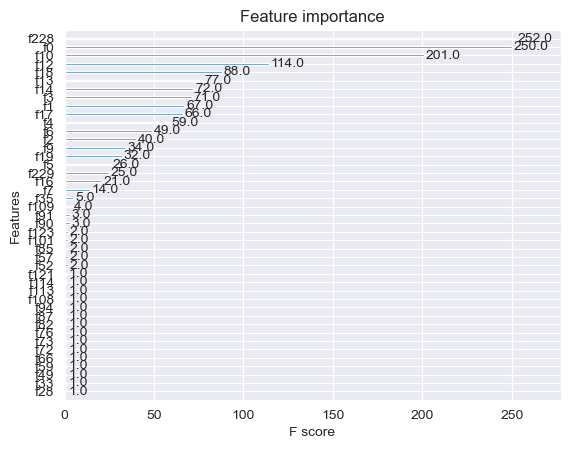

In [69]:
# xgboost模型 xgboost (**)
# 数据2：分类

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier, plot_importance #显示特征重要性
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.4, random_state=0)
clf = XGBClassifier(max_depth=2, learning_rate=1, n_estimators=1000, #弱分类树太少的话取不到更多的特征重要性
          objective='binary:logistic')
%time clf = clf.fit(X_train, y_train)
print('score : ', clf.score(X_test, y_test))

# 可视化特征重要性：xgboost自带的plot_importance
plot_importance(clf); #打印重要程度结果。


生成示例数据集:


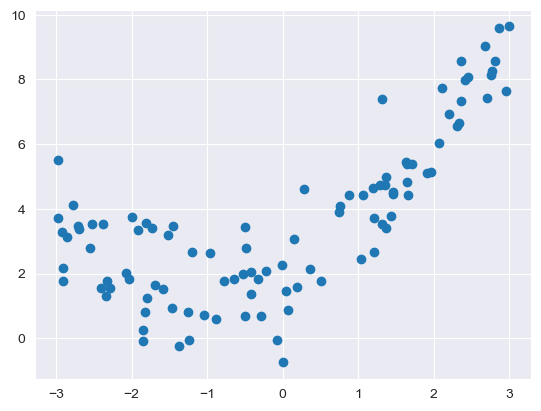

LinearRegression mse: 3.0750025765636577


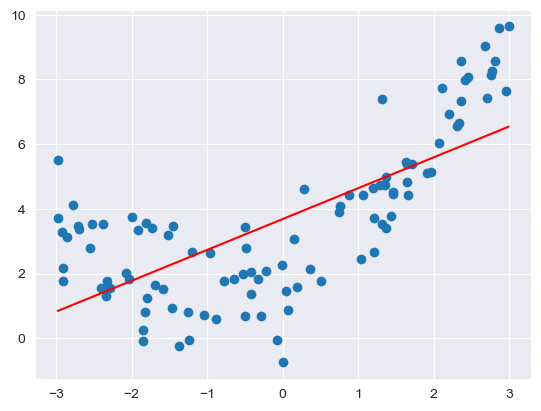

PolynomialRegression(2) mse: 1.0987392142417856


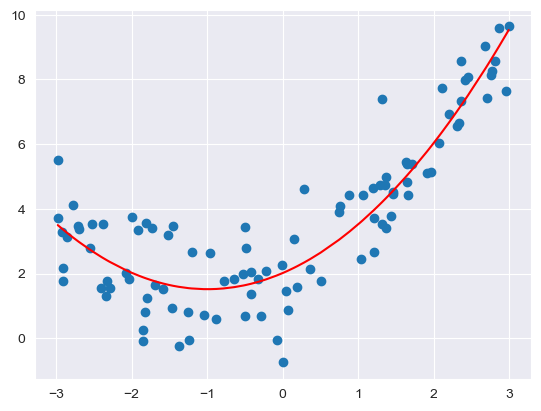

PolynomialRegression(10) mse: 1.050846676376418


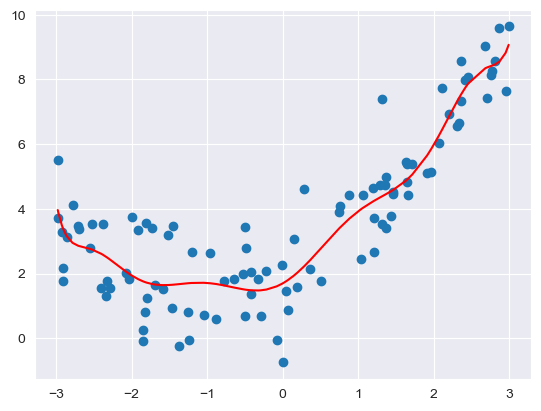

PolynomialRegression(100) mse: 0.6877438187057433


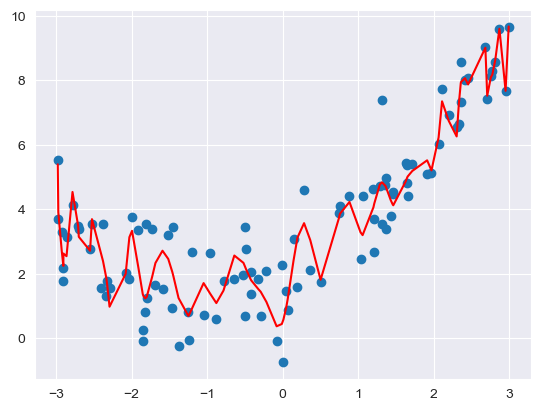

In [21]:
# 不同复杂程度模型的拟合过程
# 数据1：回归

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print("生成示例数据集:")
np.random.seed(666)
x = np.random.uniform(-3.0, 3.0, size=100)
X = x.reshape(-1, 1)
y = 0.5 * x**2 + x + 2 + np.random.normal(0, 1, size=100)
plt.scatter(x, y)
plt.show();


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 线性模型
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.score(X, y)
y_predict = lin_reg.predict(X)
print('LinearRegression mse:', mean_squared_error(y, y_predict))
mean_squared_error(y, y_predict)
y_predict = lin_reg.predict(X)
plt.scatter(x, y)
plt.plot(np.sort(x), y_predict[np.argsort(x)], color='r')
plt.show();

def PolynomialRegression(degree):
    return Pipeline([('poly', PolynomialFeatures(degree=degree)),  ('std_scaler', StandardScaler()), ('lin_reg', LinearRegression())])

# PolynomialRegression(2)
poly2_reg = PolynomialRegression(degree=2)
poly2_reg.fit(X, y)
y2_predict = poly2_reg.predict(X)
print('PolynomialRegression(2) mse:', mean_squared_error(y, y2_predict))
plt.scatter(x, y)
plt.plot(np.sort(x), y2_predict[np.argsort(x)], color='r')
plt.show();

# PolynomialRegression(10)
poly10_reg = PolynomialRegression(degree=10)
poly10_reg.fit(X, y)
y10_predict = poly10_reg.predict(X)
print('PolynomialRegression(10) mse:', mean_squared_error(y, y10_predict))
plt.scatter(x, y)
plt.plot(np.sort(x), y10_predict[np.argsort(x)], color='r')
plt.show();

# PolynomialRegression(100)
poly100_reg = PolynomialRegression(degree=100)
poly100_reg.fit(X, y)
y100_predict = poly100_reg.predict(X)
print('PolynomialRegression(100) mse:', mean_squared_error(y, y100_predict))
plt.scatter(x, y)
plt.plot(np.sort(x), y100_predict[np.argsort(x)], color='r')
plt.show();

Learning Curves (Naive Bayes):
Learning Curves (SVM, RBF kernel, $\gamma=0.001$):
Validation Curve with SVM:


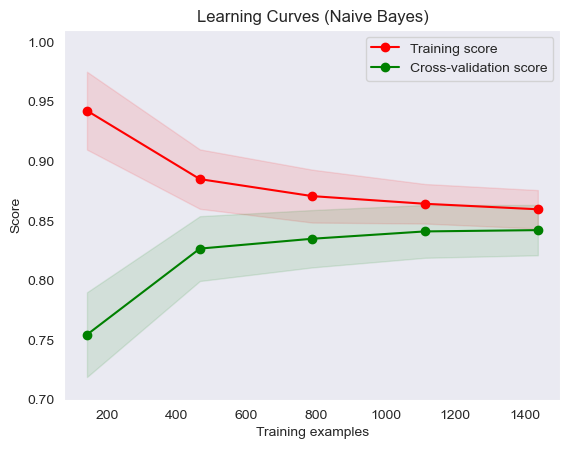

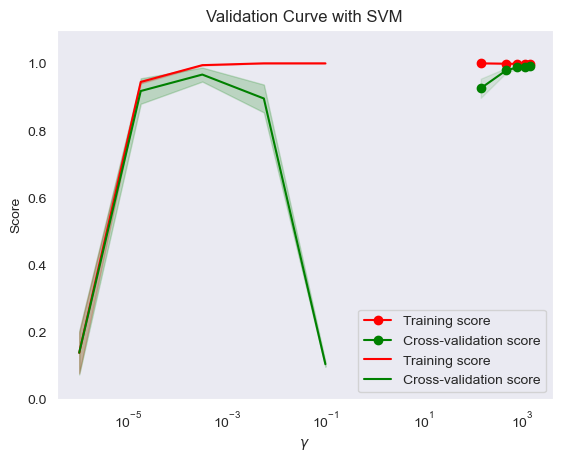

In [50]:
# 学习过程曲线
# 数据1：回归

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import ShuffleSplit, learning_curve, validation_curve

digits = load_digits()
X, y = digits.data, digits.target

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",  label="Cross-validation score")
    plt.legend(loc="best")
    return plt 


title = "Learning Curves (Naive Bayes)"
print(title+":")
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4);


title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
print(title+':')
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4);


title = "Validation Curve with SVM"
print(title+':')
param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(SVC(), X, y, param_name="gamma", param_range=param_range, cv=10, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.title(title)
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

In [54]:
# 模型正则化
# 数据1：回归

from sklearn.linear_model import SGDRegressor
poly = PolynomialFeatures(3)
train_data_poly = poly.fit_transform(train_data)
test_data_poly = poly.transform(test_data)

# L2范数正则化
clf = SGDRegressor(max_iter=1000, tol=1e-3, penalty= 'L2', alpha=0.0001) 
clf.fit(train_data_poly, train_target)
score_train = mean_squared_error(train_target, clf.predict(train_data_poly))
score_test = mean_squared_error(test_target, clf.predict(test_data_poly))
print("SGDRegressor with L2: train MSE =", score_train, "test MSE =", score_test)

# L1范数正则化
clf = SGDRegressor(max_iter=1000, tol=1e-3, penalty= 'L1', alpha=0.00001) 
clf.fit(train_data_poly, train_target)
score_train = mean_squared_error(train_target, clf.predict(train_data_poly))
score_test = mean_squared_error(test_target, clf.predict(test_data_poly))
print("SGDRegressor with L1: train MSE =", score_train, "test MSE =", score_test)

# ElasticNet L1和L2范数加权正则化
clf = SGDRegressor(max_iter=1000, tol=1e-3, penalty= 'elasticnet', l1_ratio=0.9, alpha=0.00001) 
clf.fit(train_data_poly, train_target)
score_train = mean_squared_error(train_target, clf.predict(train_data_poly))
score_test = mean_squared_error(test_target, clf.predict(test_data_poly))
print("SGDRegressor with elasticnet: train MSE =", score_train, "test MSE =", score_test)


SGDRegressor with L2: train MSE = 0.2889191411245212 test MSE = 0.2509895595332537
SGDRegressor with L1: train MSE = 0.288844377241948 test MSE = 0.2513945051912622
SGDRegressor with elasticnet: train MSE = 0.2916605510761966 test MSE = 0.25271020528839755


In [69]:
# 参数搜索调优: 调参
# 数据1：回归

from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
iris = load_iris()

# 网格搜索 
print('GridSearchCV:')
param_grid = {"gamma":[0.001,0.01,0.1,1,10,100], "C":[0.001,0.01,0.1,1,10,100]}
print("\tParameters:{}".format(param_grid))
grid_search = GridSearchCV(SVC(),param_grid,cv=5) #实例化一个GridSearchCV类
X_train,X_test,y_train,y_test = train_test_split(iris.data,iris.target,random_state=10)
grid_search.fit(X_train,y_train) #训练，找到最优的参数，同时使用最优的参数实例化一个新的SVC estimator。
# grid_search.best_estimator_
print("\tTest set score:{:.2f}".format(grid_search.score(X_test,y_test)))
print("\tBest parameters:{}".format(grid_search.best_params_))
print("\tBest score on train set:{:.2f}".format(grid_search.best_score_))

# 随机参数优化
print('RandomizedSearchCV:')
from sklearn.model_selection import RandomizedSearchCV
param_grid = {"gamma":[0.001,0.01,0.1,1,10,100], "C":[0.001,0.01,0.1,1,10,100]}
rs_search = RandomizedSearchCV(SVC(), param_grid, cv=5)
rs_search.fit(X_train,y_train)
score_test = mean_squared_error(y_test, rs_search.predict(X_test))
print("\tTest set score:{:.2f}".format(rs_search.score(X_test,y_test)))
print("\tBest parameters:{}".format(rs_search.best_params_))
print("\tBest score on train set:{:.2f}".format(rs_search.best_score_))




GridSearchCV:
	Parameters:{'gamma': [0.001, 0.01, 0.1, 1, 10, 100], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}
	Test set score:0.97
	Best parameters:{'C': 10, 'gamma': 0.1}
	Best score on train set:0.98
RandomizedSearchCV:
	Test set score:0.97
	Best parameters:{'gamma': 0.1, 'C': 10}
	Best score on train set:0.98


In [7]:
# lightGBM 调参案例
# 数据1：回归

import pandas as pd
train_data2 = pd.read_csv('./data/zhengqi/zhengqi_train.txt', sep='\t')
test_data2 = pd.read_csv('./data/zhengqi/zhengqi_test.txt', sep='\t')

train_data2_f = train_data2[test_data2.columns].values
train_data2_target = train_data2['target'].values

# lgb 模型
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
import numpy as np

# 5折交叉验证
Folds = 5
kf = KFold(n_splits=Folds, shuffle=True, random_state=2019)
# 记录训练和预测MSE
MSE_DICT = {'train_mse': [], 'test_mse': []}

# 线下训练预测
for i, (train_index, test_index) in enumerate(kf.split(train_data2_f)):
    # lgb树模型
    lgb_reg = LGBMRegressor(learning_rate=0.01, max_depth=-1, n_estimators=5000, boosting_type='gbdt',
        random_state=2019, objective='regression',)
    # 切分训练集和预测集
    X_train_KFold, X_test_KFold = train_data2_f[train_index], train_data2_f[test_index]
    y_train_KFold, y_test_KFold = train_data2_target[train_index], train_data2_target[test_index]
    # 训练模型
    lgb_reg.fit(X=X_train_KFold, y=y_train_KFold,
                eval_set=[(X_train_KFold, y_train_KFold), (X_test_KFold, y_test_KFold)],
                eval_names=['Train', 'Test'], early_stopping_rounds=100, eval_metric='MSE', verbose=50)

    # 训练集预测 测试集预测
    y_train_KFold_predict = lgb_reg.predict(X_train_KFold, num_iteration=lgb_reg.best_iteration_)
    y_test_KFold_predict = lgb_reg.predict(X_test_KFold, num_iteration=lgb_reg.best_iteration_)

    print('第{}折 训练和预测 训练MSE 预测MSE'.format(i + 1))
    train_mse = mean_squared_error(y_train_KFold_predict, y_train_KFold)
    print('------\n', '训练MSE\n', train_mse, '\n------')
    test_mse = mean_squared_error(y_test_KFold_predict, y_test_KFold)
    print('------\n', '预测MSE\n', test_mse, '\n------\n')

    MSE_DICT['train_mse'].append(train_mse)
    MSE_DICT['test_mse'].append(test_mse)
print('------\n', '训练MSE\n', MSE_DICT['train_mse'], '\n',
      np.mean(MSE_DICT['train_mse']), '\n------')
print('------\n', '预测MSE\n', MSE_DICT['test_mse'], '\n',
      np.mean(MSE_DICT['test_mse']), '\n------')

Training until validation scores don't improve for 100 rounds
[50]	Train's l2: 0.428458	Test's l2: 0.466965
[100]	Train's l2: 0.221807	Test's l2: 0.263431
[150]	Train's l2: 0.135301	Test's l2: 0.183515
[200]	Train's l2: 0.0958737	Test's l2: 0.148825
[250]	Train's l2: 0.075642	Test's l2: 0.133187
[300]	Train's l2: 0.0629311	Test's l2: 0.125237
[350]	Train's l2: 0.054088	Test's l2: 0.121321
[400]	Train's l2: 0.0473551	Test's l2: 0.118307
[450]	Train's l2: 0.0418952	Test's l2: 0.116414
[500]	Train's l2: 0.0375119	Test's l2: 0.114863
[550]	Train's l2: 0.0337062	Test's l2: 0.114002
[600]	Train's l2: 0.0303868	Test's l2: 0.112781
[650]	Train's l2: 0.02756	Test's l2: 0.11207
[700]	Train's l2: 0.0250506	Test's l2: 0.111287
[750]	Train's l2: 0.0228758	Test's l2: 0.110742
[800]	Train's l2: 0.0209081	Test's l2: 0.1103
[850]	Train's l2: 0.0191684	Test's l2: 0.109946
[900]	Train's l2: 0.0176066	Test's l2: 0.109759
[950]	Train's l2: 0.0162243	Test's l2: 0.109423
[1000]	Train's l2: 0.014984	Test's l2

[1000]	Train's l2: 0.0150397	Test's l2: 0.099986
[1050]	Train's l2: 0.0138704	Test's l2: 0.0998263
[1100]	Train's l2: 0.0128394	Test's l2: 0.0996427
[1150]	Train's l2: 0.0118688	Test's l2: 0.0996074
[1200]	Train's l2: 0.0110126	Test's l2: 0.0995783
[1250]	Train's l2: 0.0102254	Test's l2: 0.0995361
[1300]	Train's l2: 0.00951201	Test's l2: 0.0993949
[1350]	Train's l2: 0.00884199	Test's l2: 0.0992683
[1400]	Train's l2: 0.00822777	Test's l2: 0.0993064
[1450]	Train's l2: 0.00767529	Test's l2: 0.0992335
[1500]	Train's l2: 0.00712999	Test's l2: 0.0992797
Early stopping, best iteration is:
[1423]	Train's l2: 0.00797142	Test's l2: 0.0992124
第5折 训练和预测 训练MSE 预测MSE
------
 训练MSE
 0.007971416523938925 
------
------
 预测MSE
 0.09921237825179019 
------

------
 训练MSE
 [0.0014891170026875994, 0.0072898318628357595, 0.0204510246350711, 0.009355847634266074, 0.007971416523938925] 
 0.009311447531759892 
------
------
 预测MSE
 [0.10539809256060709, 0.13269660321638646, 0.10111932554955037, 0.106821900982

In [26]:
# 调参案例2：lightgbm + hyperopt
# 数据1：回归

import lightgbm as lgb
from hyperopt import hp, fmin, tpe
from numpy.random import RandomState
from sklearn.model_selection import KFold
import sys, os

def feature_select_wrapper(train, test, label):
    _original_stdout = sys.stdout # 输出重定向（设定）
    sys.stdout = open(os.devnull, 'w') # 输出重定向（设定）
    features = train.columns.tolist()
    features.remove(label)
    # 配置模型的训练参数
    params_initial = {'num_leaves': 31, 'learning_rate': 0.1, 'boosting': 'gbdt', 'min_child_samples': 20, 'bagging_seed': 2020, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7, 'max_depth': -1, 'metric': 'rmse', 'reg_alpha': 0, 'reg_lambda': 1, 'objective': 'regression' }
    kf = KFold(n_splits=5, random_state=2020, shuffle=True)
    fse = pd.Series(0, index=features)
    for train_part_index, eval_index in kf.split(train[features], train[label]):
        print(train[features].shape, train[label].shape)
        # 模型训练
        train_part = lgb.Dataset(train[features].iloc[train_part_index], train[label].iloc[train_part_index])
        eval = lgb.Dataset(train[features].iloc[eval_index], train[label].iloc[eval_index])
        model = lgb.train(params_initial, train_part, num_boost_round=10000, valid_sets=[train_part, eval], valid_names=['train', 'valid'], early_stopping_rounds=30, verbose_eval=50)
        fse += pd.Series(model.feature_importance(), features)
    feature_select = fse.sort_values(ascending=False).index.tolist()[:300]
    sys.stdout.close() # 输出重定向（还原）
    sys.stdout = _original_stdout # 输出重定向（还原）
    return train[feature_select + [label]], test[feature_select], model.feature_importance()
def params_append(params):
    params['objective'] = 'regression'
    params['metric'] = 'rmse'
    params['bagging_seed'] = 2020
    return params
def param_hyperopt(train, label):
    features = train.columns.tolist()
    features.remove(label)
    train_data = lgb.Dataset(train[features], train[label], silent=True)
    lgb.feature_pre_filter = False
    def hyperopt_objective(params):
        params = params_append(params)
        # print(params)
        _original_stdout = sys.stdout # 输出重定向（设定）
        sys.stdout = open(os.devnull, 'w') # 输出重定向（设定）
        res = lgb.cv(params, train_data, 1000, nfold=2, stratified=False, shuffle=True, metrics='rmse', early_stopping_rounds=20, verbose_eval=False, show_stdv=False, seed=2020)
        sys.stdout.close() # 输出重定向（还原）
        sys.stdout = _original_stdout # 输出重定向（还原）
        index = res['rmse-mean'].index(min(res['rmse-mean']))
        print('rmse: mean = ' + str(res['rmse-mean'][index]) + ', stdv = ' + str(res['rmse-stdv'][index]))
        return res['rmse-mean'][index]
    params_space = {'learning_rate': hp.uniform('learning_rate', 1e-2, 5e-1), 'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
        'feature_fraction': hp.uniform('feature_fraction', 0.5, 1), 'num_leaves': hp.choice('num_leaves', list(range(10, 300, 10))),
        'reg_alpha': hp.randint('reg_alpha', 0, 10), 'reg_lambda': hp.uniform('reg_lambda', 0, 10),
        'bagging_freq': hp.randint('bagging_freq', 1, 10), 'min_child_samples': hp.choice('min_child_samples', list(range(1, 30, 5))), 'feature_pre_filter':'false'}
    params_best = fmin(hyperopt_objective, space=params_space, algo=tpe.suggest, max_evals=30, rstate=RandomState(2020))
    print('best parameters:', params_best)
    return params_best

if __name__ == "__main__":
    # pandas.Dataframe
    train, test, feature_importance = feature_select_wrapper(train_data, test_data, 'target')
    best_clf = param_hyperopt(train, 'target')

rmse: mean = 0.39560381032953973, stdv = 0.000897187586141851
rmse: mean = 0.4278982756887534, stdv = 0.003053170072809197                     
rmse: mean = 0.37234017514299944, stdv = 0.0075128341334049775                   
rmse: mean = 0.39583657254974436, stdv = 0.004572492833138125                    
rmse: mean = 0.374383309403573, stdv = 0.016692697543662177                      
rmse: mean = 0.3830427008380757, stdv = 0.0007606682887919269                    
rmse: mean = 0.3818953412664797, stdv = 0.009277425009617896                     
rmse: mean = 0.3609773795343162, stdv = 0.01117958110311143                      
rmse: mean = 0.3529414388654882, stdv = 0.007893074882562523                     
rmse: mean = 0.37825614551328457, stdv = 0.011134068090891819                   
rmse: mean = 0.37715488353764437, stdv = 0.0026057210296076827                   
rmse: mean = 0.3601317538172102, stdv = 0.009908512096079763                     
rmse: mean = 0.3750499638381267, stdv

In [45]:
# 调参案例3：xgboost + BayesianOptimization
# 数据1：回归

import xgboost as xgb
from bayes_opt import BayesianOptimization

def param_beyesian(train, label):
    features = train.columns.tolist()
    train_y = train[label]
    features.remove(label)
    train_matrix = train[features].values
    sample_index = train_y.sample(frac=0.1, random_state=2020).index.tolist()
    train_data = xgb.DMatrix(train_matrix[sample_index, :], train_y.loc[sample_index].values, silent=True)
    def xgb_cv(colsample_bytree, subsample, min_child_weight, max_depth, reg_alpha, eta, reg_lambda):
        _original_stdout = sys.stdout # 输出重定向（设定）
        sys.stdout = open(os.devnull, 'w') # 输出重定向（设定）
        params = {'objective': 'reg:squarederror', 'early_stopping_round': 50, 'eval_metric': 'rmse'}
        params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
        params['subsample'] = max(min(subsample, 1), 0)
        params["min_child_weight"] = int(min_child_weight)
        params['max_depth'] = int(max_depth)
        params['eta'] = float(eta)
        params['reg_alpha'] = max(reg_alpha, 0)
        params['reg_lambda'] = max(reg_lambda, 0)
        # print(params)
        cv_result = xgb.cv(params, train_data, num_boost_round=1000, nfold=2, seed=2, stratified=False, shuffle=True, early_stopping_rounds=30, verbose_eval=False)
        sys.stdout.close() # 输出重定向（还原）
        sys.stdout = _original_stdout # 输出重定向（还原）
        # cv_result: pandas.core.frame.DataFrame, [train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std]
        test_rmse_mean, test_rmse_std = cv_result['test-rmse-mean'].tolist(), cv_result['test-rmse-std'].tolist()
        index = test_rmse_mean.index(min(test_rmse_mean))
        print('rmse: mean = ' + str(test_rmse_mean[index]) + ', std = ' + str(test_rmse_std[index]))
        return -min(cv_result['test-rmse-mean'])
    xgb_bo = BayesianOptimization(xgb_cv, {'colsample_bytree': (0.5, 1), 'subsample': (0.5, 1), 'min_child_weight': (1, 30), 'max_depth': (5, 12), 'reg_alpha': (0, 5), 'eta':(0.02, 0.2), 'reg_lambda': (0, 5)})
    xgb_bo.maximize(init_points=21, n_iter=5)  # init_points表示初始点，n_iter代表迭代次数（即采样数）
    print(-xgb_bo.max['target'], xgb_bo.max['params'])
    return xgb_bo.max['params']

if __name__ == "__main__":
    # pandas.Dataframe
    best_clf = param_beyesian(train, 'target')
    

|   iter    |  target   | colsam... |    eta    | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
rmse: mean = 0.6939754925164031, std = 8.505373637168745e-05
| 1         | -0.694    | 0.5711    | 0.1229    | 8.665     | 3.658     | 4.412     | 2.387     | 0.9114    |
rmse: mean = 0.6973715304624193, std = 0.021168200569523454
| 2         | -0.6974   | 0.9934    | 0.1842    | 11.49     | 27.42     | 4.42      | 0.5234    | 0.5375    |
rmse: mean = 0.6692494723047557, std = 0.024692539854973883
| 3         | -0.6692   | 0.6078    | 0.1822    | 6.569     | 6.614     | 0.908     | 1.192     | 0.9216    |
rmse: mean = 0.6558967164690909, std = 0.021150634471355345
| 4         | -0.6559   | 0.951     | 0.1099    | 6.457     | 15.72     | 1.765     | 1.18      | 0.5107    |
rmse: mean = 0.6762620705919726, std = 0.021639353727133603
| 5         | -0.6763   | 0.7119    | 0

In [54]:
# 调参案例4：catboost
# 还需要使用gpu才能跑通

from sklearn.model_selection import KFold
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import roc_auc_score

def train_predict(train, label):
    features = train.columns.tolist()
    train_y = train[label]
    features.remove(label)
    kf = KFold(n_splits=5, random_state=2020, shuffle=True)
    prediction_test = 0
    prediction_train = pd.Series()
    score_train = []
    for train_part_index, eval_index in kf.split(train[features], train[label]):
        learn_pool = Pool(train[features].iloc[train_part_index], train[label].iloc[train_part_index], text_features=[], cat_features= [], feature_names=features)
        test_pool = Pool(train[features].iloc[eval_index], train[label].iloc[eval_index], text_features=[], cat_features= [], feature_names=features)
        test_y = test_pool.get_label()
        model = CatBoostClassifier(iterations=100, learning_rate=0.1, eval_metric='AUC', task_type='GPU')
        model.fit(learn_pool, eval_set=test_pool, verbose=50)
        score_train.append(model.best_score_['validation']['AUC'])
        print(roc_auc_score(test_y, prediction_test))
    train_auc_mean = sum(score_train)/5
    print('mean auc on train  = ' + str(train_auc_mean))
    return train_auc_mean, test_auc_mean

if __name__ == "__main__":
    # pandas.Dataframe
    train_auc_mean, test_auc_mean = train_predict(train_data, 'target')
    

Index(['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30',
       'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'target'],
      dtype='object')


/var/folders/6l/8jb84y794gz98hv20bv2jlmw0000gn/T/ipykernel_4617/3930985435.py:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prediction_train = pd.Series()


CatBoostError: /Users/zomb-ml-platform-msk/go-agent-21.2.0/pipelines/BuildMaster/catboost.git/catboost/libs/train_lib/trainer_env.cpp:9: Environment for task type [GPU] not found